In [1]:
#Import Libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
# Read the memory intensive file
df = pd.read_parquet('CLEANED_V9.1.parquet')

print(df.columns.tolist())

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
df.dtypes

# Convert float64 to float32
float_cols = df.select_dtypes(include='float64').columns
df[float_cols] = df[float_cols].astype('float32')

# Convert int64 to int32
int_cols = df.select_dtypes(include='int64').columns
df[int_cols] = df[int_cols].astype('int32')

['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code', 'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO', 'STD_temp_scaled', 'STD_dwpt_scaled', 'STD_rhum_scaled', 'STD_prcp_scaled', 'STD_snow_scaled', 'STD_wdir_scaled', 'STD_wspd_scaled', 'STD_wpgt_scaled', 'STD_pres_scaled', 'STD_tsun_scaled', 'STD_coco_scaled', 'STA_temp_scaled', 'STA_dwpt_scaled', 'STA_rhum_scaled', 'STA_prcp_scaled', 'STA_snow_scaled', 'STA_wdir_scaled', 'STA_wspd_scaled', 'STA_wpgt_scaled', 'STA_pres_scaled', 'STA_tsun_scaled', 'STA_coco_scaled', 'STD_UTC_time_of_day_cosine', 'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year', 'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day', 'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine', 'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday', 'STA_UTC_hour_of_day', 'final_pred_dep', 'Y_arrival']


In [3]:
X = df.drop(columns = ["Y_arrival"])
y = df["Y_arrival"] 

catFeat = X.select_dtypes(include='category').columns.tolist() 
catFeat

['Airline Code',
 'Aircraft Registration',
 'Operator',
 'Type Code',
 'Mode S',
 'Serial Number',
 'FROM',
 'TO']

In [4]:
# 60 % training, 40 % temp (to split into test and validation)  
xTrain, xTemp, yTrain , yTemp = train_test_split(X, y, test_size = 0.4, random_state = 42) 

# 20 % test, 20 % validation 
xTest, xVal, yTest, yVal = train_test_split(xTemp, yTemp, test_size = 0.5, random_state = 42) 

xTrain.shape, xTest.shape, xVal.shape

((7001872, 44), (2333957, 44), (2333958, 44))

In [5]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'max_depth': 6,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'gamma': 0,
    'verbosity': 0,
    'seed': 42,
    'early_stopping_rounds': 10,
    'enable_categorical': True,  # Enable experimental support for categorical data
    'tree_method': 'hist',
    'device': 'cuda'
}

# Define the parameter grid for gridsearch
param_grid = {
    'max_depth': [3, 6, 9],               # Controls tree depth
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate
    'n_estimators': [100, 200, 300],      # Number of trees
    'colsample_bytree': [0.8, 1.0],       # Fraction of features to use
    'subsample': [0.8, 1.0],              # Fraction of samples to use
    'gamma': [0, 0.1, 0.2]                # Minimum loss reduction for splitting
}

# Train the XGBoost model
model = XGBClassifier(**params)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='accuracy',           # Metric to optimize
#     cv=3,                         # Number of cross-validation folds
#     verbose=2,                    # Verbosity level
#     n_jobs=-1                     # Use all available CPU cores
# )

# RandomisedSearch in case cpu cannot handle
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1  # Disable parallel processing
)

# Fit GridSearchCV
grid_search.fit(xTrain, yTrain, eval_set=[(xVal, yVal)])

# Extract the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[0]	validation_0-logloss:0.65315
[1]	validation_0-logloss:0.64708
[2]	validation_0-logloss:0.64180
[3]	validation_0-logloss:0.63745
[4]	validation_0-logloss:0.63281
[5]	validation_0-logloss:0.62923
[6]	validation_0-logloss:0.62604
[7]	validation_0-logloss:0.62320
[8]	validation_0-logloss:0.62071
[9]	validation_0-logloss:0.61840
[10]	validation_0-logloss:0.61581
[11]	validation_0-logloss:0.61386
[12]	validation_0-logloss:0.61228
[13]	validation_0-logloss:0.61055
[14]	validation_0-logloss:0.60943
[15]	validation_0-logloss:0.60774
[16]	validation_0-logloss:0.60645
[17]	validation_0-logloss:0.60543
[18]	validation_0-logloss:0.60427
[19]	validation_0-logloss:0.60302
[20]	validation_0-logloss:0.60224
[21]	validation_0-logloss:0.60152
[22]	validation_0-logloss:0.60084
[23]	validation_0-logloss:0.59936
[24]	validation_0-logloss:0.59851
[25]	validation_0-logloss:0.59755
[26]	validation_0-logloss:0.59677
[27]	validation_0-logloss:0.595

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix , classification_report 

# predict probabilities on the validation set 
yValidatePredProbability = best_model.predict(xVal) 
#convert them to binary 
yValidatePred = (yValidatePredProbability > 0.5).astype(int) 

#accuracy 
validationAccuracy = accuracy_score(yVal, yValidatePred) 
print ("Validation Accuracy: ", validationAccuracy) 

#AUC 
validationAUC = roc_auc_score(yVal, yValidatePredProbability) 
print ("Validation AUC: ", validationAUC) 

#confusion matrix
confusionMatrix = confusion_matrix(yVal, yValidatePred) 
print ("Confusion Matrix: \n", confusionMatrix) 

#classification report 
classificationReport = classification_report(yVal, yValidatePred) 
print ("Classification Report: \n", classificationReport) 

Validation Accuracy:  0.7288417357981591
Validation AUC:  0.6795165918495514
Confusion Matrix: 
 [[1278569  184953]
 [ 447919  422517]]
Classification Report: 
               precision    recall  f1-score   support

       False       0.74      0.87      0.80   1463522
        True       0.70      0.49      0.57    870436

    accuracy                           0.73   2333958
   macro avg       0.72      0.68      0.69   2333958
weighted avg       0.72      0.73      0.72   2333958



In [7]:
yTestPredProbability = best_model.predict(xTest) 
yTestPred = (yTestPredProbability > 0.5).astype(int) 

testAccuracy = accuracy_score(yTest, yTestPred) 
print ("Test Accuracy: ", testAccuracy) 

testAUC = roc_auc_score(yTest, yTestPredProbability) 
print ("Test AUC: ", testAUC) 

testConfusionMatrix = confusion_matrix(yTest, yTestPred) 
print ("Test Confusion Matrix: \n", testConfusionMatrix) 

testClassificationReport = classification_report(yTest, yTestPred) 
print ("Test Classification Report: \n", testClassificationReport) 

Test Accuracy:  0.7287040849510081
Test AUC:  0.679474621499255
Test Confusion Matrix: 
 [[1278091  183877]
 [ 449316  422673]]
Test Classification Report: 
               precision    recall  f1-score   support

       False       0.74      0.87      0.80   1461968
        True       0.70      0.48      0.57    871989

    accuracy                           0.73   2333957
   macro avg       0.72      0.68      0.69   2333957
weighted avg       0.72      0.73      0.72   2333957



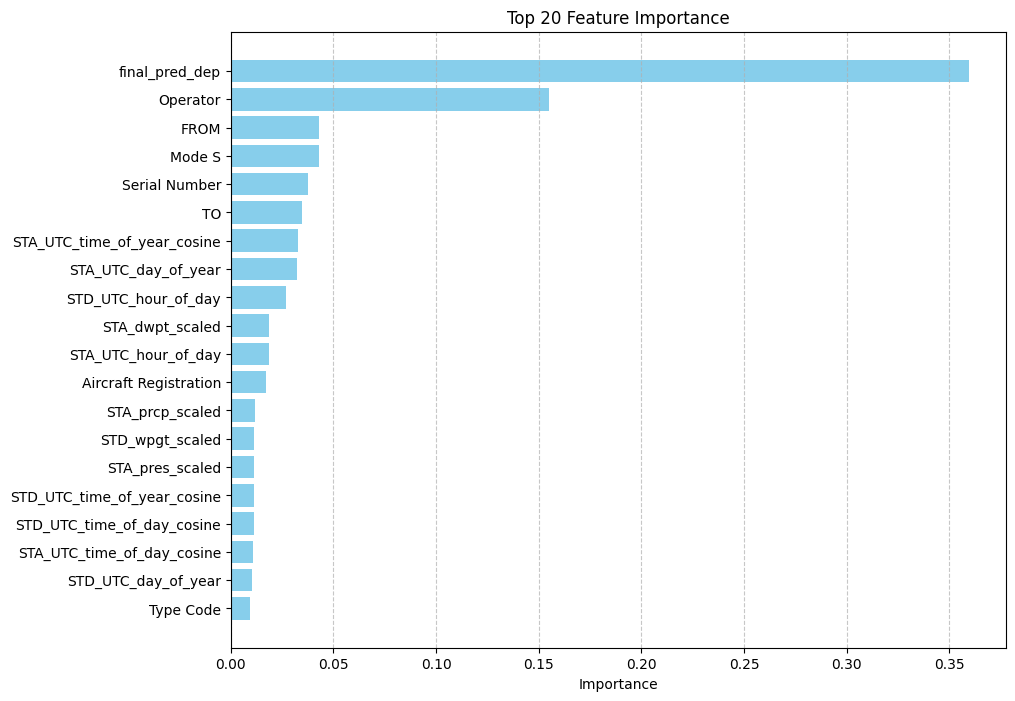

In [8]:
# Get Feature Importance
importance = best_model.feature_importances_
feature_names = X.columns

# Get indices of top 20 most important features
top_n = 20
sorted_indices = np.argsort(importance)[-top_n:]  # Get indices of top 20 features

# Sort features and importance scores by importance
top_feature_names = np.array(feature_names)[sorted_indices]
top_importance_scores = np.array(importance)[sorted_indices]


# Plot Top 20 Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(top_feature_names, top_importance_scores, color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()